In [ ]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import cartopy.crs as ccrs

In [ ]:
def create_four_centered_patches(
    species_distribution: torch.Tensor,
    patch_lat_size: int = 64,
    patch_lon_size: int = 128,
) -> list:
    """
    Creates four centered patches of shape (patch_lat_size, patch_lon_size)
    from a full grid of shape (H, W), here expected to be (152, 320).

    Args:
      species_distribution: Tensor with shape [S, 152, 320] (S = number of species).
      patch_lat_size (int): The patch height (default=64).
      patch_lon_size (int): The patch width (default=128).

    Returns:
      List[torch.Tensor]: Four patches each of shape [S, patch_lat_size, patch_lon_size].
    """
    # Ensure the input shape is as expected
    S, full_lat, full_lon = species_distribution.shape
    assert full_lat == 152 and full_lon == 320, (
        f"Expected input shape to be (S, 152, 320), got {species_distribution.shape}"
    )
    
    total_crop_lat = 2 * patch_lat_size  # Should be 128 when patch_lat_size = 64
    total_crop_lon = 2 * patch_lon_size  # Should be 256 when patch_lon_size = 128
    
    lat_margin = (full_lat - total_crop_lat) // 2  # (152 - 128) // 2 = 12
    lon_margin = (full_lon - total_crop_lon) // 2   # (320 - 256) // 2 = 32

    # Top-left patch:
    patch_top_left = species_distribution[
        :, 
        lat_margin : lat_margin + patch_lat_size, 
        lon_margin : lon_margin + patch_lon_size
    ]
    # Top-right patch:
    patch_top_right = species_distribution[
        :, 
        lat_margin : lat_margin + patch_lat_size, 
        lon_margin + patch_lon_size : lon_margin + 2 * patch_lon_size
    ]
    # Bottom-left patch:
    patch_bottom_left = species_distribution[
        :, 
        lat_margin + patch_lat_size : lat_margin + 2 * patch_lat_size, 
        lon_margin : lon_margin + patch_lon_size
    ]
    # Bottom-right patch:
    patch_bottom_right = species_distribution[
        :, 
        lat_margin + patch_lat_size : lat_margin + 2 * patch_lat_size, 
        lon_margin + patch_lon_size : lon_margin + 2 * patch_lon_size
    ]
    
    return [
        patch_top_left,
        patch_top_right,
        patch_bottom_left,
        patch_bottom_right,
    ]
def create_four_anchor_patches(
    species_distribution: torch.Tensor,
    patch_lat_size: int = 64,
    patch_lon_size: int = 128,
    vertical_anchor: str = "center",
    horizontal_anchor: str = "center",
    lat_ascending: bool = True
) -> list:
    """
    Creates four patches of size (patch_lat_size, patch_lon_size) from the full grid,
    placing the overall cropped region according to the specified anchors.
    
    The function extracts a region of size (2*patch_lat_size, 2*patch_lon_size)
    from the full (H=152, W=320) grid, then splits that region into four patches:
      [top_left, top_right, bottom_left, bottom_right]

    Parameters:
      species_distribution (Tensor): shape [S, 152, 320] (S = # of species/channels)
      patch_lat_size (int): Desired patch height. (Default=64)
      patch_lon_size (int): Desired patch width.  (Default=128)
      vertical_anchor (str): One of {"top","center","bottom"}.
      horizontal_anchor (str): One of {"left","center","right"}.
      lat_ascending (bool): If True (default), row=0 is the bottom (south) and row=H-1 is the top (north).
                            If False, row=0 is the top and row=H-1 is the bottom.

    Returns:
      A list of 4 Tensors: each [S, patch_lat_size, patch_lon_size].
    """
    S, full_lat, full_lon = species_distribution.shape
    assert full_lat == 152 and full_lon == 320, (
        f"Expected input grid shape [S, 152, 320], but got {species_distribution.shape}"
    )
    
    crop_height = 2 * patch_lat_size  # e.g., 128 if patch_lat_size=64
    crop_width  = 2 * patch_lon_size  # e.g., 256 if patch_lon_size=128

    if vertical_anchor == "center":
        row_start = (full_lat - crop_height) // 2  # e.g., (152-128)//2=12
    elif vertical_anchor == "bottom":
        if lat_ascending:
            # Ascending lat => bottom anchor = row_start=0
            row_start = 0
        else:
            # Descending lat => bottom anchor = row_start=full_lat-crop_height
            row_start = full_lat - crop_height
    elif vertical_anchor == "top":
        if lat_ascending:
            # Ascending lat => top anchor = row_start= full_lat - crop_height
            row_start = full_lat - crop_height
        else:
            # Descending lat => top anchor = row_start=0
            row_start = 0
    else:
        raise ValueError("vertical_anchor must be one of ['top','center','bottom']")

    if horizontal_anchor == "center":
        col_start = (full_lon - crop_width) // 2  # e.g., (320-256)//2=32
    elif horizontal_anchor == "left":
        col_start = 0
    elif horizontal_anchor == "right":
        col_start = full_lon - crop_width
    else:
        raise ValueError("horizontal_anchor must be one of ['left','center','right']")
    
    # top-left patch
    patch_top_left = species_distribution[
        :,
        row_start : row_start + patch_lat_size,
        col_start : col_start + patch_lon_size
    ]

    # top-right patch
    patch_top_right = species_distribution[
        :,
        row_start : row_start + patch_lat_size,
        col_start + patch_lon_size : col_start + 2*patch_lon_size
    ]

    # bottom-left patch
    patch_bottom_left = species_distribution[
        :,
        row_start + patch_lat_size : row_start + 2*patch_lat_size,
        col_start : col_start + patch_lon_size
    ]

    # bottom-right patch
    patch_bottom_right = species_distribution[
        :,
        row_start + patch_lat_size : row_start + 2*patch_lat_size,
        col_start + patch_lon_size : col_start + 2*patch_lon_size
    ]
    print(f"top left size {patch_top_left.shape}, top right {patch_top_right.shape}, bottom left {patch_bottom_left.shape}, bottom_right {patch_bottom_right.shape}")

    patches = [patch_top_left, patch_top_right, patch_bottom_left, patch_bottom_right]
    return patches, row_start, col_start
#  print(f"top left size {patch_top_left.shape}, top right {patch_top_right.shape}, bottom left {patch_bottom_left.shape}, bottom_right {patch_bottom_right.shape}")

def save_patches_to_folder(
    patches: list,
    out_dir: Path,
    base_filename: str
):
    """
    Saves the four patches to disk as .pt files.

    Args:
      patches: A list of 4 patch tensors, each shape [S, 64, 128].
      out_dir: The directory to save the .pt files.
      base_filename: A base name (without extension). 
                     We'll create e.g. base_filename_patch_0.pt, etc.
    """
    out_dir.mkdir(parents=True, exist_ok=True)
    for i, patch_tensor in enumerate(patches):
        filename = out_dir / f"{base_filename}_patch_{i}.pt"
        torch.save(patch_tensor, filename)
        print(f"Saved patch {i} to {filename}")

def load_and_stitch_patches(
    patch_files: list,
    patch_lat_size: int = 64,
    patch_lon_size: int = 128,
):
    """
    Loads four patch files from disk and stitches them into a (S, 128, 256) tensor.

    Args:
      patch_files: List of 4 file paths for the .pt patch files.
      patch_lat_size (int): 64 by default.
      patch_lon_size (int): 128 by default.

    Returns:
      A stitched tensor of shape [S, 128, 256].
    """
    # patch_files should be a list with 4 .pt file paths.
    assert len(patch_files) == 4, f"Expected 4 patch files. Got {len(patch_files)}"

    # Load them
    patches = [torch.load(p, weights_only=True) for p in patch_files]
    # Each patch shape: [S, 64, 128]
    # We'll combine them:
    # top_row = torch.cat([patch_top_left, patch_top_right], dim=-1) => [S, 64, 128+128=256]
    # bottom_row = ...
    # then final = torch.cat([top_row, bottom_row], dim=-2)

    patch_top_left    = patches[0]
    patch_top_right   = patches[1]
    patch_bottom_left = patches[2]
    patch_bottom_right= patches[3]

    top_row    = torch.cat([patch_top_left, patch_top_right], dim=-1)   # shape [S, 64, 256]
    bottom_row = torch.cat([patch_bottom_left, patch_bottom_right], dim=-1) # [S, 64, 256]
    stitched   = torch.cat([top_row, bottom_row], dim=-2)              # [S, 128, 256]
    return stitched
 

In [ ]:
def plot_stitched_overlay(
    stitched_data: torch.Tensor,
    lat_original,    # can be list or np.array; full grid latitudes (length 152)
    lon_original,    # full grid longitudes (length 320)
    row_start: int,  # dynamic starting row from patch extraction
    col_start: int,  # dynamic starting col from patch extraction
    patch_lat_size: int = 64,
    patch_lon_size: int = 128,
    title: str = "Stitched Overlay"
):
    """
    Overlays the stitched patch (of shape [S, 2*patch_lat_size, 2*patch_lon_size])
    on the full coordinate grid. The stitched patch is assumed to have been cropped 
    from the full grid starting at row_start, col_start.
    """
    # Convert lat_original and lon_original to NumPy arrays, if not already
    lat_original = np.asarray(lat_original)
    lon_original = np.asarray(lon_original)
    
    crop_height = 2 * patch_lat_size  # 128
    crop_width  = 2 * patch_lon_size   # 256

    # Compute the appropriate subset of the full coordinate arrays
    sub_lat = lat_original[row_start: row_start + crop_height]
    sub_lon = lon_original[col_start: col_start + crop_width]

    # For plotting, choose channel 0 (or another if preferred)
    channel_to_plot = 0
    data_for_plot = stitched_data[channel_to_plot].numpy()  # shape: (crop_height, crop_width)
    
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 6))
    ax.set_extent([lon_original[0], lon_original[-1], lat_original[0], lat_original[-1]], crs=ccrs.PlateCarree())
    ax.coastlines(resolution="50m")
    ax.set_title(title)
    
    Lon_grid, Lat_grid = np.meshgrid(sub_lon, sub_lat)
    norm = TwoSlopeNorm(vmin=data_for_plot.min(), vcenter=0, vmax=data_for_plot.max())
    cf = ax.contourf(Lon_grid, Lat_grid, data_for_plot,
                    levels=60, cmap='RdBu_r', norm=norm, alpha=0.6, transform=ccrs.PlateCarree())
    # (For better viz - Optional) Draw a rectangle around the cropped (stitched) region using dynamic row_start and col_start.
    # Determine geographic coordinates of the cropped region:
    # rect = Rectangle(
    #     (lon_original[col_start], lat_original[row_start]),
    #     lon_original[col_start + crop_width - 1] - lon_original[col_start],
    #     lat_original[row_start + crop_height - 1] - lat_original[row_start],
    #     linewidth=2, edgecolor='red', facecolor='none', transform=ccrs.PlateCarree()
    # )
    # ax.add_patch(rect)
    fig.colorbar(cf, ax=ax, orientation="vertical", label="Value")
    plt.tight_layout()
    plt.show()

In [ ]:
def process_one_data_point_example(data, out_dir: Path, file_prefix: str,
                                   vertical_anchor: str = "center",
                                   horizontal_anchor: str = "center",
                                   lat_ascending: bool = True):
    """
    Example of how you might use these functions in your code for a single sample.

    data: the dictionary from your dataset's __getitem__, containing "species_distribution"
          or your pre-processed x, etc. Typically shape is [T, S, 152, 320].
    out_dir: where to store the resulting patches.
    file_prefix: a prefix for naming the saved patch files.

    Returns:
      stitched_data (torch.Tensor) of shape [S, 128, 256]
    """
    # Suppose the data has shape [T, S, 152, 320], and want to work with T=1:
    # e.g. species_distribution[1, :, :, :] => shape [S, 152, 320].
    distribution_3d = data["y"]  # shape [S, 152, 320]
    print(f"Fistribution 3_d shape  {distribution_3d.shape}")
    # Create 4 centered patches:
    # Bottom aligned: 
    #patches = create_four_anchor_patches(my_distribution, vertical_anchor="bottom", horizontal_anchor="center")
    # Left aligned
    # patches = create_four_anchor_patches(my_distribution, vertical_anchor="center", horizontal_anchor="left")

    patches, row_start, col_start = create_four_anchor_patches(
        distribution_3d,
        patch_lat_size=64,
        patch_lon_size=128,
        vertical_anchor=vertical_anchor,
        horizontal_anchor=horizontal_anchor,
        lat_ascending=lat_ascending
    )
    # Save the patches as .pt
    save_patches_to_folder(patches=patches, out_dir=out_dir, base_filename=file_prefix)

    # Re-load them and stitch them back:
    patch_files = [
        out_dir / f"{file_prefix}_patch_{i}.pt" for i in range(4)
    ]
    stitched_data = load_and_stitch_patches(patch_files)

    # Return the stitched data so we can plot or do further processing:
    return stitched_data, row_start, col_start



Original lat 152 | lon 320
Fistribution 3_d shape  torch.Size([500, 152, 320])
top left size torch.Size([500, 64, 128]), top right torch.Size([500, 64, 128]), bottom left torch.Size([500, 64, 128]), bottom_right torch.Size([500, 64, 128])
Saved patch 0 to patch_outputs/sample001_patch_0.pt
Saved patch 1 to patch_outputs/sample001_patch_1.pt
Saved patch 2 to patch_outputs/sample001_patch_2.pt
Saved patch 3 to patch_outputs/sample001_patch_3.pt
torch.Size([500, 128, 256])


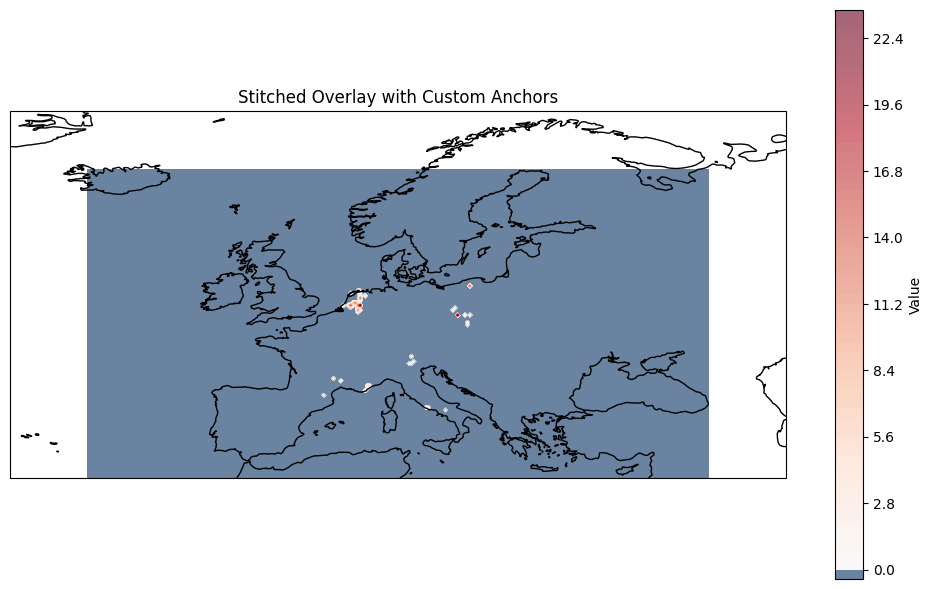

In [ ]:
from datamodule import GeoLifeCLEFSpeciesDatasetOLD
DATA_DIR = "/home/thanasis.trantas/github_projects/gravity_wave_finetuning/data/finetune/geolifeclef24/aurorashape_species/val"

dataset = GeoLifeCLEFSpeciesDatasetOLD(data_dir=DATA_DIR, geo_size=(152, 320))
lat_original = np.asarray(dataset[0]["lat_original"])
lon_original = np.asarray(dataset[0]["lon_original"])
print(f"Original lat {len(lat_original)} | lon {len(lon_original)}")
real_data = dataset[0]
# print(real_data.shape)
# new_data = real_data.numpy()

out_dir = Path("./patch_outputs")
file_prefix = "sample001"

stitched_data, row_start, col_start = process_one_data_point_example(real_data, out_dir, file_prefix,
                                                                     vertical_anchor="bottom",
                                                                        horizontal_anchor="center",
                                                                        lat_ascending=False)

print(stitched_data.shape)
plot_stitched_overlay(
        stitched_data=stitched_data,
        lat_original=lat_original,
        lon_original=lon_original,
        row_start=row_start,
        col_start=col_start,
        patch_lat_size=64,
        patch_lon_size=128,
        title="Stitched Overlay with Custom Anchors"
    )


In [25]:
# stitched_data.shape
x = stitched_data[0, :, 0]
x.shape

torch.Size([128])

In [26]:
x

tensor([-0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341, -0.0341,
        -0.0341, -0.0341, -0.0341, -0.03